<a href="https://colab.research.google.com/github/arthur5775/CS_ML/blob/main/LPC_source_filter_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Arthur Grossmann--Le Mauguen

# TP2: Linear predictive coding and the source-filter model of speech production

Si vous travaillez sur Google Colab, voici un bout de code à exécuter en début de notebook pour télécharger les ressources nécessaires dans votre environnement en ligne :



In [1]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XCix8wnCM7sV3f_ryUz5qi1eNZQeOfrn' -O resources.zip
!unzip -o resources.zip

--2025-12-07 22:03:08--  https://docs.google.com/uc?export=download&id=1XCix8wnCM7sV3f_ryUz5qi1eNZQeOfrn
Resolving docs.google.com (docs.google.com)... 74.125.203.102, 74.125.203.138, 74.125.203.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.203.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1XCix8wnCM7sV3f_ryUz5qi1eNZQeOfrn&export=download [following]
--2025-12-07 22:03:09--  https://drive.usercontent.google.com/download?id=1XCix8wnCM7sV3f_ryUz5qi1eNZQeOfrn&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.157.132, 2404:6800:4008:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.157.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6245995 (6.0M) [application/octet-stream]
Saving to: ‘resources.zip’

resources.zip       100%[===================>]   5.96M  14.7MB/s    

<a id='1'></a>


## 1. Introduction

### 1.1 Generalities

In telephony, the  sampling rate of speech signals is chosen to ensure the intelligibility of the message and allow for speaker indentification. These conditions are fullfiled by keeping the frequency band [0 - 4] kHz, known as the voice band. Therefore, we choose a sampling frequency of 8 kHz.

### 1.2 Speech sounds

We distinguish two types of speech sounds:

1. Voiced sounds, with a quasi-periodic waveform. Vowels are a perfect example of voiced sounds.
2. Unvoiced sounds, with a noise-like waveform.

Vowels are typically longer than consonants. There exist multiple types of consonants:

- nasals which are voiced, such as /m/ or /n/;
- fricatives which can be voiced in /v/, /z/, /j/ or unvoiced in /f/, /s/, /ch/;
- plosives which can be voiced  in /b/, /d/, /g/ or unvoiced in /p/, /t/, /k/;
- liquids which are voiced, such as /l/ or /r/.

### 1.3 Source-filter speech model

<img src="./figures/block_diagram.png" width="500px" align="center">

One of the most important concepts for characterizing the structure of speech signals is deduced from the source-filter model proposed by Fant in 1970. In this model the speech signal is seen as a sound source that has undergone spectral modifications according to the shape of the vocal tract, which acts as an acoustic filter. As we have seen, a vocal source can be either voiced, when there is vibration of the vocal folds, or unvoiced, when a turbulent noise is created at a constriction, or following a sudden relaxation of an occlusion in the vocal tract.

The two types of speech sounds, voiced and unvoiced, can be modeled as the output of an [all-pole (infinite impulse response) linear filter](https://en.wikipedia.org/wiki/Infinite_impulse_response), whose order (number of coefficients) ranges between 10 and 20, and whose input is:

- a white noise signal for unvoiced sounds;
- a periodic pulse train for voiced sounds.

The pulse train associated with voiced sounds corresponds to the sequence of openings and closings of the glottis (the space between the vocal folds), openings being much longer that closings. During the closing phases, the sudden reduction in the air flow causes a brief pulse. The fundamental frequency of this periodic signal is called the pitch.

<img src="./figures/vocal_fold_signal.png" width="400px" align="center">

<img src="./figures/vocal_fold_signal_zoom.png" width="550px" align="center">

For a man, the pitch varies between 90 and 270 Hz, for a woman it varies between 120 and 360 Hz, and for a child between 200 and 600 Hz. For a given speaker, the pitch changes through the conversation, it is part of the prosody.

The vocal tract acts as a set of resonators, and gives rise to resonances at specific frequencies which are called the formant frequencies.

<img src="./figures/formants.png" width="650px" align="center">

Credits for Figures 4.33, 4.34 and 4.38: David Howard, Jamie Angus. Acoustics and Psychoacoustics, Fourth Edition (2009, Focal Press).


<a id='2'></a>
## 2. Theoretical part

### 2.1 Mathematical representation of the source-filter model

#### Time-domain representation

In the **source-filter model**, a speech signal is represented as the output of an [all-pole filter](https://en.wikipedia.org/wiki/Infinite_impulse_response) taking a source signal as input. This model can be formalized in the (discrete) time domain $t \in \mathbb{Z}$ as follows:

$$ x(t) + \sum_{i=1}^P a_i x(t-i) = w(t), \qquad (1) $$

where

- $x(t)$ is the speech signal (output);
- $w(t)$ is the source signal (input);
- $P$ is the order of the filter (a hyper-parameter of the model);
- $\{a_i\}_{i=1}^P$ are the filter coefficients (the parameters of the model).

In the following, we will assume that $x(t)$ is of finite time support $\{0,....,T-1\}$.

#### Transfer function

_Remark: If you do not have a sufficient background in signal processing to fully understand the discussion below about the transfer function, just read it quickly as it is not the most important, and focus on understanding what comes next, which builds upon the concepts we have seen in previous lessons._

The [transfer function](https://en.wikipedia.org/wiki/Transfer_function) of a filter describes the relationship between the input and output signals. For our speech modeling problem, it characterizes the propagation of the source signal through the vocal tract.

The transfer function is defined as the ratio of the output and input signals' [Z-transforms](https://en.wikipedia.org/wiki/Z-transform). It is obtained by taking the Z-transform of each side of equation (1) and using the [time-shift](https://en.wikipedia.org/wiki/Z-transform#Properties) property of the Z-transform:

$$ X(z) + \sum_{i=1}^P a_i z^{-i}X(z) = W(z),$$

which leads to:
$$ \displaystyle X(z) = H(z) W(z), \qquad H(z) = \frac{1}{1 + \sum\limits_{i=1}^P a_i z^{-i}}. $$

The transfer function $H(z)$ exhibits resonances at the zeros of the polynomial $A(z) = 1 + \sum_{i=1}^P a_i z^{-i}$, which are called the poles of the filter. Note that a transfer function generally takes the form of a ratio of polynomials in $z$. The zeros of the polynomial in the numerator are called the "zeros" of the filter, and the zeros of the polynomial in the denominator are called the "poles". We now understand why we say that the source-filter model corresponds to an all-pole filter. To be stable, all the poles of the filter need to be contained within the unit circle, i.e., we should have $A(z) \neq 0$ for $|z| \ge 1$.

#### Frequency-domain representation

---

**Exercise 2.1**

Equation (1) characterizes the source-filter model in the time domain, i.e., it describes the relationship between the source and the speech signals in the time domain. We would like to study their relationship also in the frequency domain, which is the purpose of this exercise.

1. You have to take the discrete Fourier transform (DFT) of order $F$ on both sides of equation (1) and use the [shift property](https://en.wikipedia.org/wiki/Discrete_Fourier_transform#Shift_theorem) to obtain a relationship of the form $X(f) = H(f) W(f)$, where $X(f)$ and $W(f)$ are the DFT of order $F$ of $x(t)$ and $w(t)$. You will give the expression of $H(f)$.

2. What does $H(f)$ represent in the source-filter model of speech production?

---


---

**Solution**

1. The goal is to apply the Discrete Fourier Transform (DFT) of order $F$ to the time-domain equation of the source-filter model (Equation 1) to find a relationship in the frequency domain:
$$ X(f) = H(f) W(f)$$
The time-domain representation is:
$$ x(t) + \sum_{i=1}^P a_i x(t-i) = w(t) $$
for t ∈ {0,...,T-1}

a) Applying the Discrete Fourier Transform (DFT)  
The DFT of a signal $g(t)$ is denoted by $G(f)$.  
Applying the DFT of order $F$ to both sides of Equation (1):
$$ DFT (x(t) + \sum_{i=1}^P a_i x(t-i)) = DFT (w(t)) $$
Due to the linearity of the DFT:
$$ DFT (x(t)) + DFT(\sum_{i=1}^P a_i x(t-i)) = DFT (w(t)) $$
$$ X(f) + \sum_{i=1}^P a_i DFT (x(t-i)) = W(f) $$

b) Using the Shift Property of the DFT  
The shift property states that the DFT of a time-shifted signal, $x(t-i)$, is $X(f) e^{-j 2 \pi f \frac{i}{F}}$, where $f$ is the frequency index ($f \in \{0, \dots, F-1\}$).  
Substituting the shift property into the equation:

$$ X(f) + \sum_{i=1}^{P} a_i \left(X(f) e^{-j 2 \pi f \frac{i}{F}}\right) = W(f) $$

c) Deriving $H(f)$  
Factor out $X(f)$ on the left side:
$$ X(f) (1 + \sum_{i=1}^{P} a_i e^{-j 2 \pi f \frac{i}{F}} = W(f) $$  
To match the form $X(f) = H(f) W(f)$, we isolate $X(f)$:  
$$X(f) = \frac{1}{1 + \sum_{i=1}^{P} a_i e^{-j 2 \pi f \frac{i}{F}}} W(f)$$

2. In the source-filter model, $H(f)$ represents the filter, which is the vocal tract that modifies the sounds produced by the vocal folds (cordes vocales en français).

---

The squared modulus of the frequency response is called the **spectral envelope**, and it is widely used in speech signal analysis.

### 2.2 Linear predictive coding

The source-filter model tells us that a speech signal results from the all-pole filtering of a source signal, which we formalized above in the time domain with equation (1) and in the frequency domain with equation (2). We are now going to see that this exact same source-filter model can be interpreted from the perspective of [**linear prediction**](https://en.wikipedia.org/wiki/Linear_prediction), which will be useful for estimating the source-filter model parameters from an actual recording of a speech signal.

In one sentence, linear prediction consists of predicting the future sample of a discrete-time signal as a linear function of the current and previous samples. This is possible for signals that have correlated samples, which is the case for many natural signals including speech. Indeed, nature is not random and produces structured signals, for instance correlated in the time domain, or sparse in the time-frequency domain. Signal processing aims to transcribe this structure into mathematical models that are used to derive algorithms to solve problems. The fact that samples in a speech signal are correlated means that we should be able to compress the signal without loosing too much information. This is the main principle behind  [linear predictive coding](https://en.wikipedia.org/wiki/Linear_predictive_coding) (LPC), which is at the basis of [Voice over IP (VoIP)](https://en.wikipedia.org/wiki/Voice_over_IP), an example of technology that definitely changed how humans communicate.

LPC allows us to compute a compressed representation of the speech signal (at the encoder), that basically corresponds to the above source-filter model parameters $\{a_i\}_{i=1}^P$. These parameters can be transmitted through a channel, using a much smaller bitrate than if the raw speech signal had to be transmitted. Finally, they can be used to reconstruct the speech signal (at the decoder). This is the basis of the [LPC-10](https://en.wikipedia.org/wiki/FIPS_137) speech coding algorithm that was developed by the United States Department of Defense in 1984. The [code-excited linear prediction](https://en.wikipedia.org/wiki/Code-excited_linear_prediction) (CELP) coding algorithm was then proposed in 1985, and it provided significantly better quality than LPC-10. CELP is for instance used in the [MPEG-4 Audio](https://en.wikipedia.org/wiki/MPEG-4_Part_3) standard.

Let us define the linear prediction of the speech signal by:

$$\hat{x}(t) = - \sum_{i=1}^P a_i x(t-i). \qquad (3)$$

We are linearly combining the previous samples $x(t-i)$ using the coefficients $a_i$, $i = 1,...,P$, to compute the predicted signal $\hat{x}(t)$. The error associated with this estimate, usually called the **prediction residual**, is given by:

$$ e(t) = x(t) - \hat{x}(t). \qquad (4) $$

Identifying (1) and (4) we see that the residual corresponds to the source signal in the source-filter model.

We assume that there are $T$ speech samples available to estimate the model parameters, $x(t), t=0,...,T-1$. The first sample that can be predicted in terms of past $P$ samples is thus $x(P)$ (we could also consider that $x(t) = 0$ for $t < 0$).

We are going to use the least squares estimation method to estimate the model parameters $\{a_i\}_{i=1}^P$. It consists in finding the prediction coefficients that minimize the total squared prediction error over the interval $[P, T-1]$ defined by:

$$ \mathcal{L}(a_1, a_2, ..., a_P) = \sum_{t=P}^{T-1} e(t)^2 = \sum_{t=P}^{T-1}  \left( x(t) + \sum_{i=1}^P a_i x(t-i) \right)^2.$$

We remind that the extrememum of a quadratic function can be found by setting its derivative to zero. This extrememum is a minimum if the second derivative is positive.

---
**Exercise 2.2**


By setting the partial derivative $\displaystyle \frac{\partial \mathcal{L}}{\partial a_j}, j=1,...,P$, to zero, identify a system of $P$ equations of the form

$$ \mathbf{r} = - \mathbf{R} \mathbf{a}, \qquad \mathbf{r} \in \mathbb{R}^P, \mathbf{R} \in \mathbb{R}^{P \times P}, \mathbf{a} = \begin{pmatrix} a_1 \\ \vdots \\ a_P \end{pmatrix} \in \mathbb{R}^P, \qquad (5)$$

that the prediction coefficients should satisfy. You will define $\mathbf{r}$ and $\mathbf{R} $ using

$$ c(i,j) = \sum_{t=P}^{T-1} x(t-i) x(t-j), \qquad (i,j) \in \{0,...,P\} \times \{1,...,P\}.$$
    
---

---

**Solution**

Let $j\in\{1,...,P\}$,
$$
\begin{aligned}
& \frac{\partial \mathcal{L}}{\partial a_j} = \sum_{t=P}^{T-1} 2 x(t-j) \left(x(t) + \sum_{i=1}^P a_i x(t-i)\right) = 0 \\
\Leftrightarrow &\ \sum_{t=P}^{T-1}x(t-j)x(t) + \sum_{i=1}^P \left(\sum_{t=P}^{T-1}x(t-i) x(t-j) \right) a_i =0 \\
⇔\ & c(0,j) + \sum_{i=1}^Pc(i,j)a_i = 0 \\
⇔\ & c(0,j) = - \sum_{i=1}^Pc(i,j)a_i = 0 \ = -\begin{pmatrix}c(1, j) & c(2, j) & ... & c(P,j)\end{pmatrix} \mathbf{a}\\
\end{aligned}
$$
We obtain

$$
\begin{aligned}
&\begin{cases}
c(0,1) = -\begin{pmatrix}c(1, 1) & c(2, 1) & ... & c(P,1)\end{pmatrix} \mathbf{a} \\
c(0,2) = -\begin{pmatrix}c(1, 2) & c(2, 2) & ... & c(P,2)\end{pmatrix} \mathbf{a} \\
\vdots \\
c(0,P) = -\begin{pmatrix}c(1, P) & c(2, P) & ... & c(P,P)\end{pmatrix} \mathbf{a}
\end{cases}\\
⇔&\ \begin{pmatrix} c(0,1) \\ c(0, 2) \\ ... \\ c(0, P) \end{pmatrix} =
-\begin{pmatrix}c(1, 1) & c(2, 1) & ... & c(P,1) \\ c(1, 2) & c(2, 2) & ... & c(P,2) \\ \vdots & \vdots & \ddots & \vdots \\ c(1, P) & c(2, P) & ... & c(P,P) \end{pmatrix} \mathbf{a}\\
\end{aligned}
$$

Which is why: $\mathbf{r}=-\mathbf{Ra}$ with

$$
\mathbf{r} = \begin{pmatrix} c(0,1) \\ c(0, 2) \\ ... \\ c(0, P) \end{pmatrix},\
\mathbf{R} = \begin{pmatrix}c(1, 1) & c(2, 1) & ... & c(P,1) \\ c(1, 2) & c(2, 2) & ... & c(P,2) \\ \vdots & \vdots & \ddots & \vdots \\ c(1, P) & c(2, P) & ... & c(P,P) \end{pmatrix}
$$

---

We could show that $\mathbf{R}$ is invertible because, as a sample covariance matrix it is symmetric positive definite ([under some assumptions](https://stats.stackexchange.com/a/53105)). Therefore, the optimal prediction coefficients in the minimum mean squared error (MMSE) sense are given by:

$$ \mathbf{a}^\star = - \mathbf{R}^{-1} \mathbf{r}.$$

_Remark_: The solution to the LPC problem is very closely related to the Yule-Walker equations for the estimation on an autoregressive (AR) model parameters. This is precisely because if we define the source signal $w(t)$ (which corresponds to the residual $e(t)$ for the LPC) in the source-filter model as a white Gaussian noise we obtain an AR model. If you are interested, the AR perspective of the source-filter model is detailed in the appendix.


<a id='3'></a>
## 3. Practical work


In [5]:
import matplotlib
import IPython.display as ipd
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import scipy as sp
import librosa
import librosa.display
from utils import plot_waveform, plot_spectrum, plot_spectrogram
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

Let's first load a speech signal.

8000


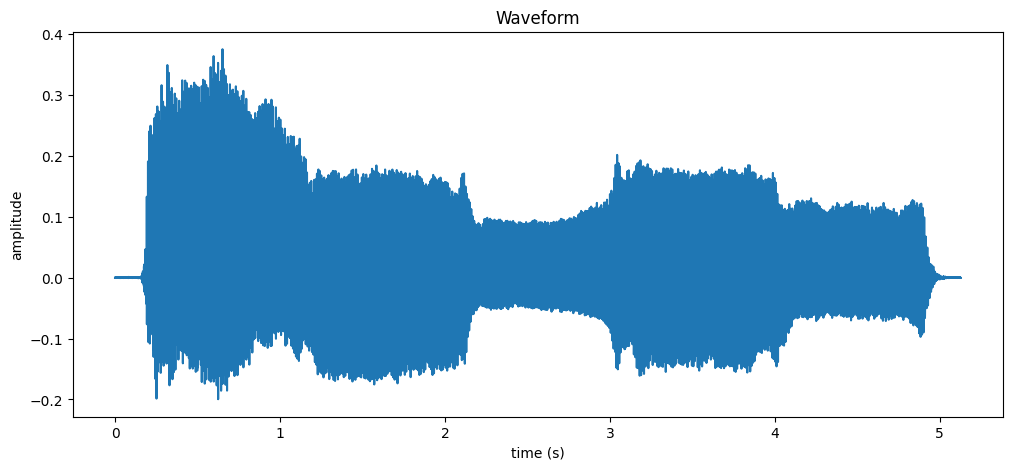

In [6]:
x_all, fs = sf.read('./data/aeiou_8k.wav')

print(fs)

plot_waveform(x_all, fs)

ipd.Audio(x_all, rate=fs)

In the function `plot_spectrogram` of `utils.py`, we use the toolbox [librosa](https://librosa.github.io/librosa/) to compute the power spectrogram.

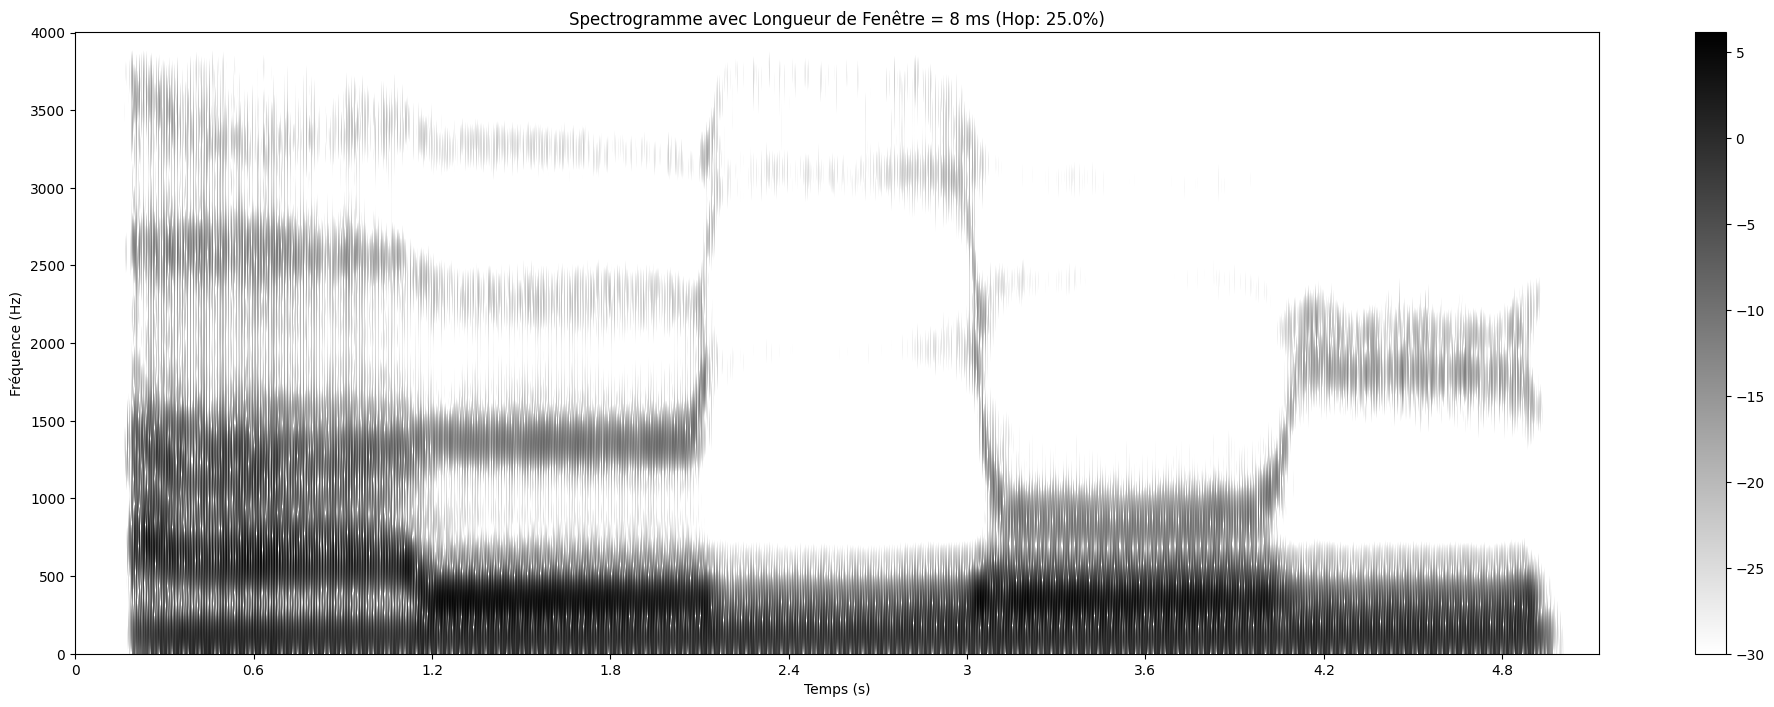

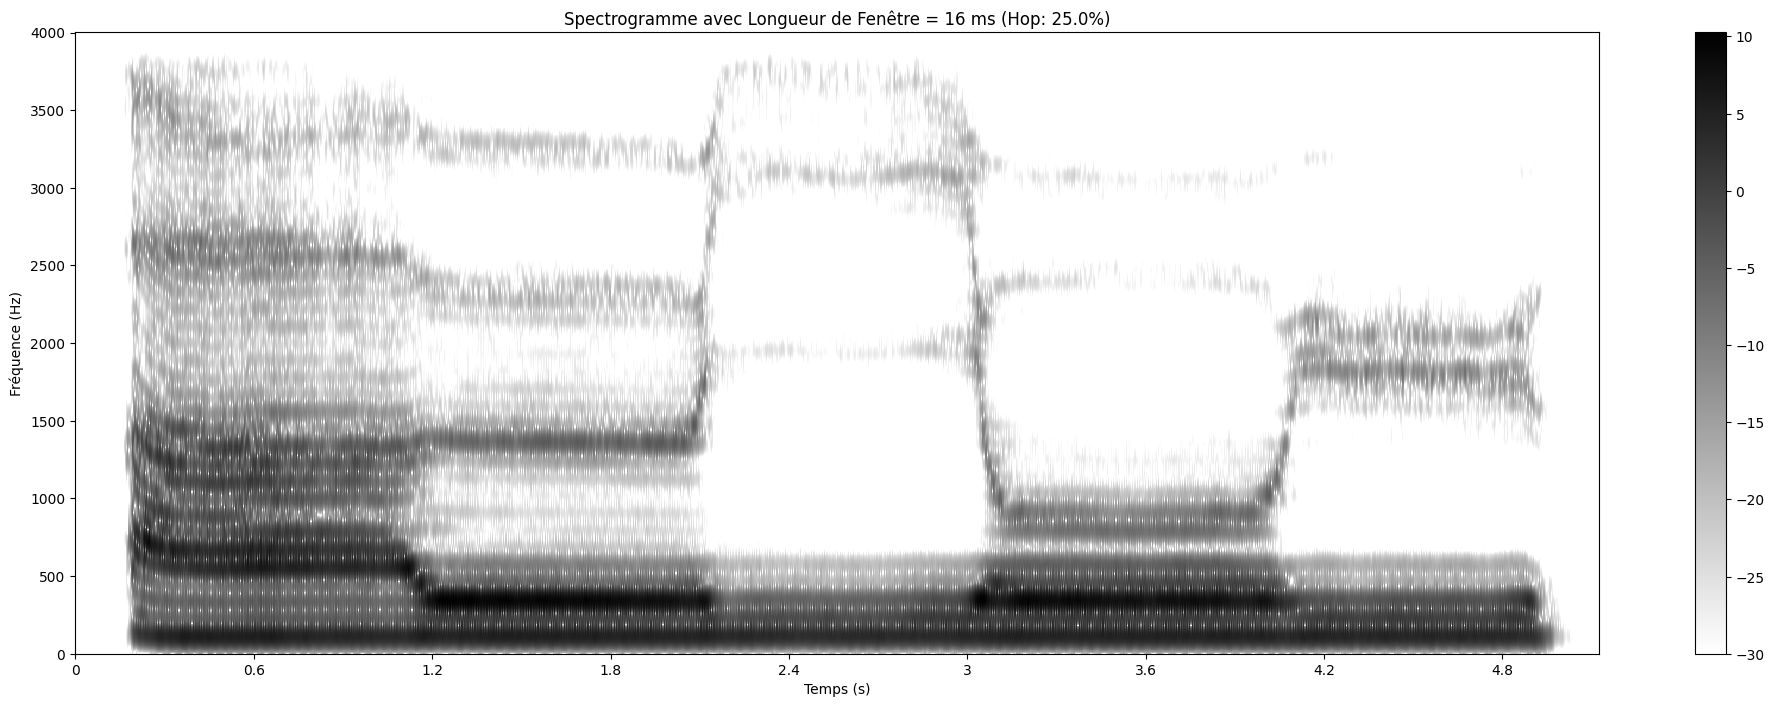

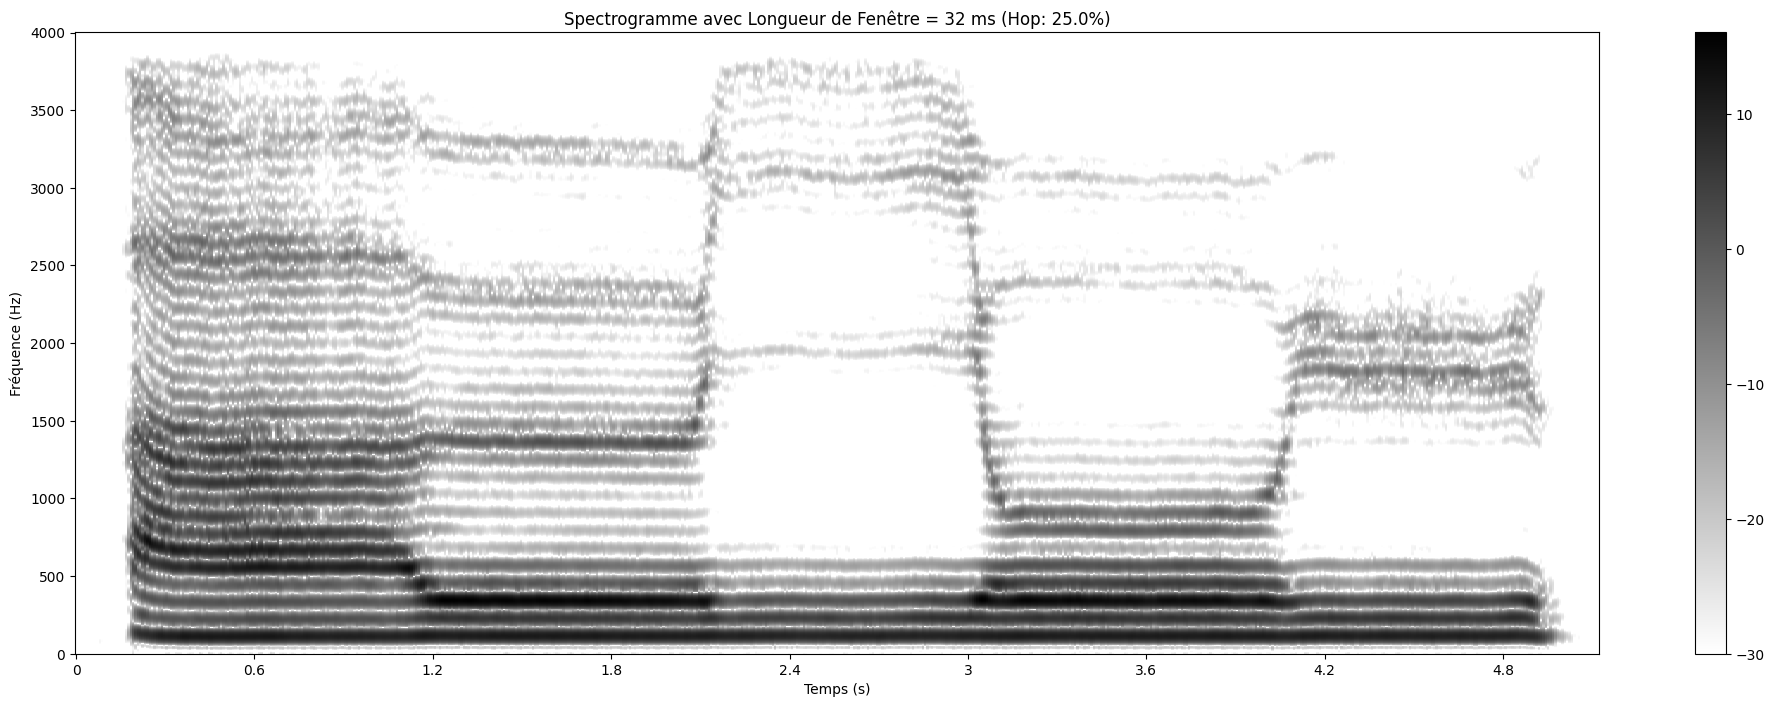

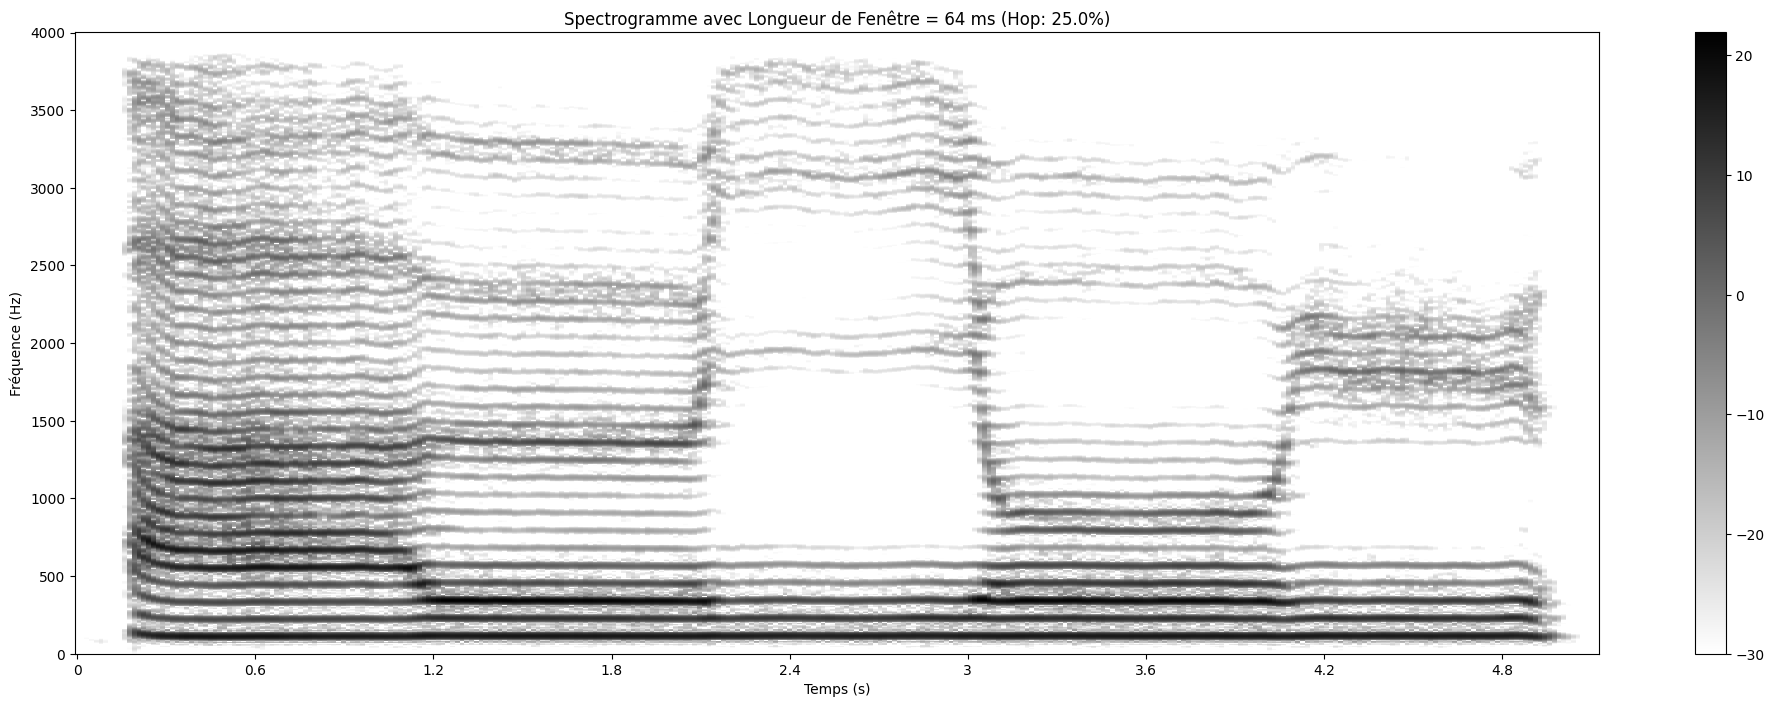

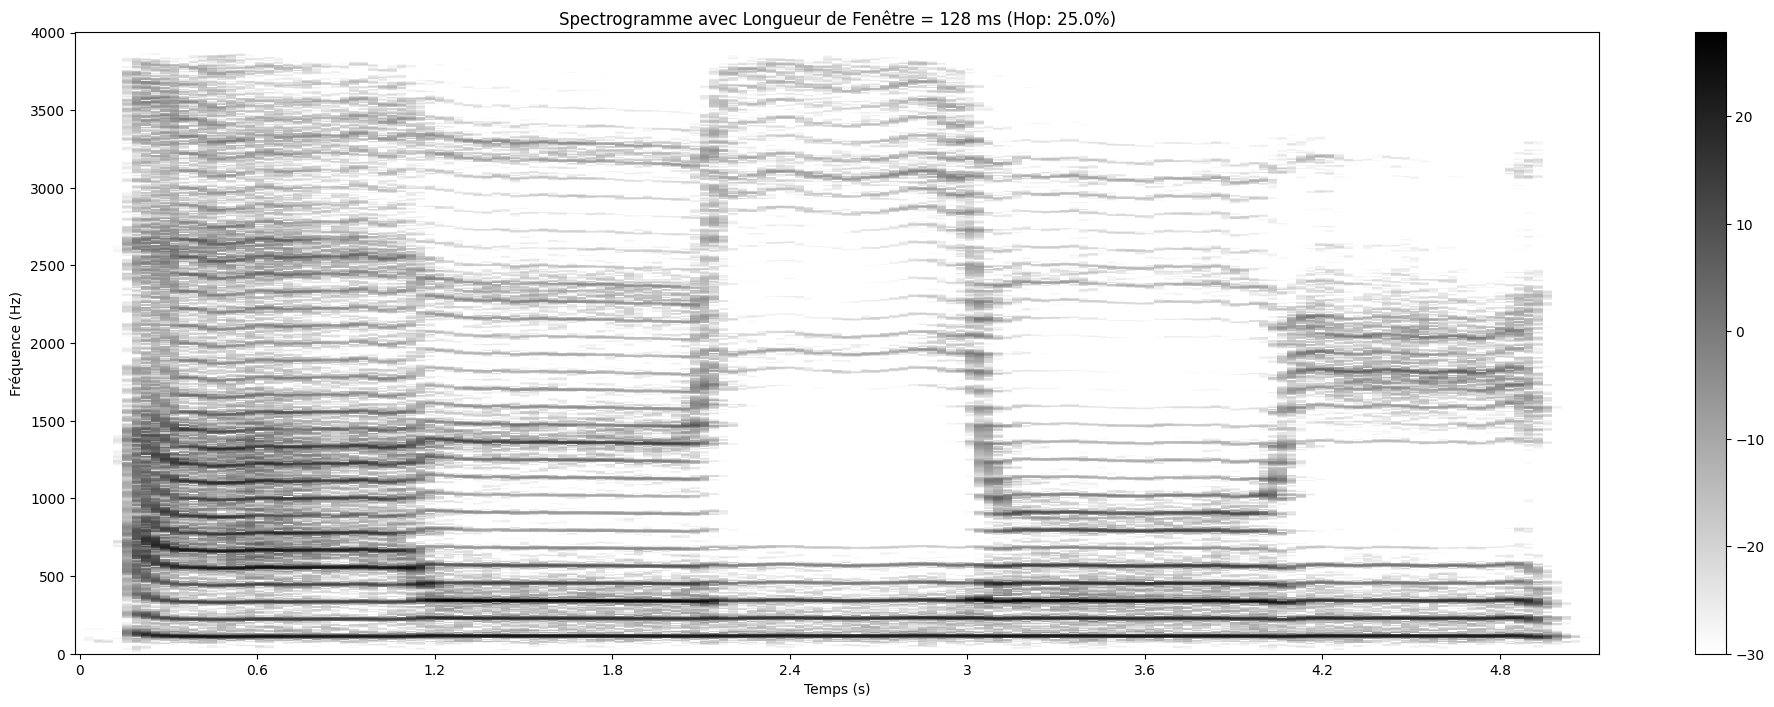

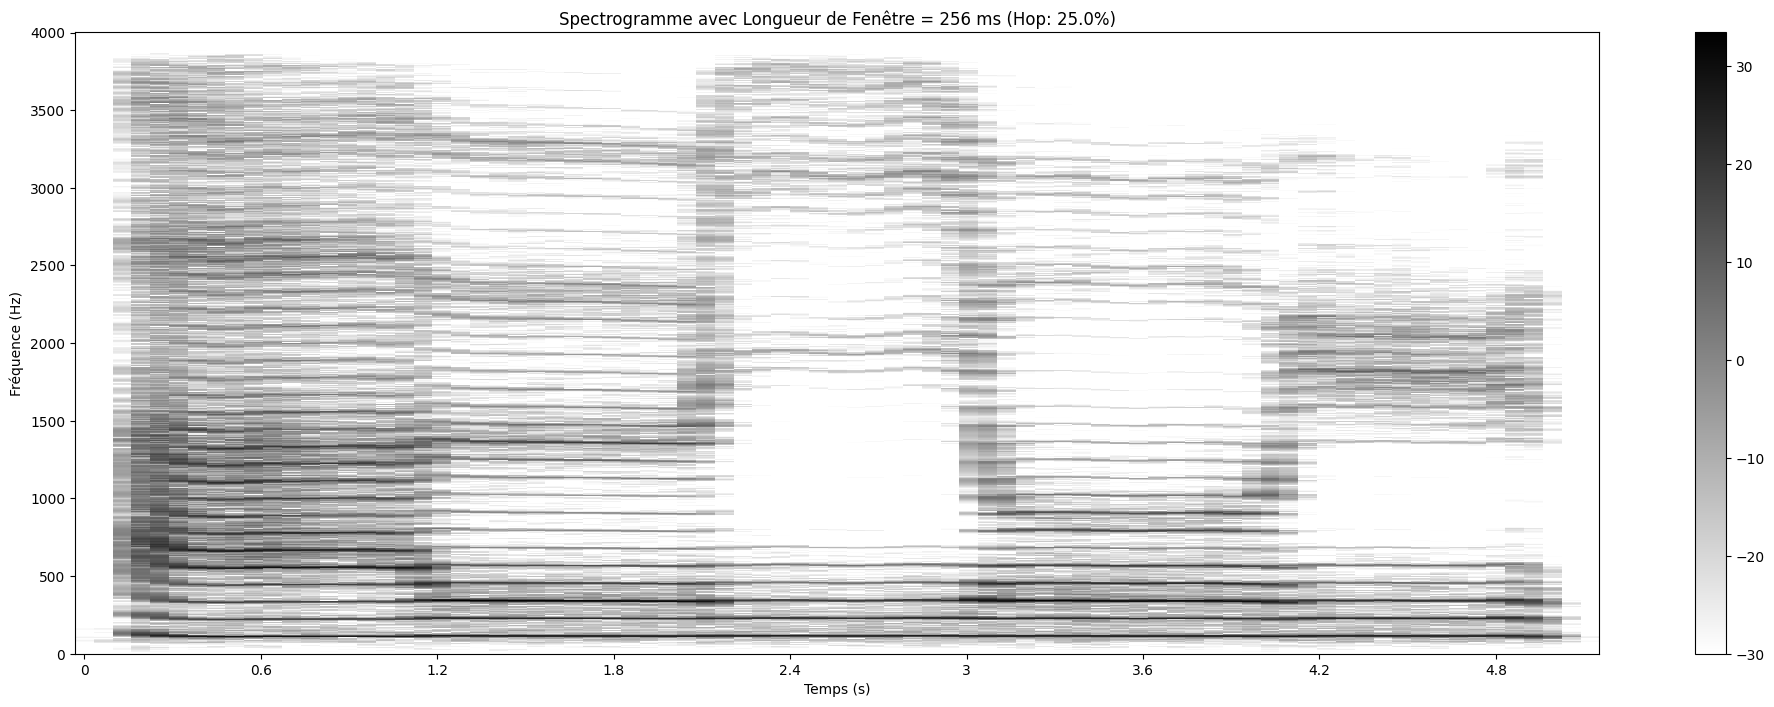

In [ ]:
wlen_sec_values = [8e-3, 16e-3, 32e-3, 64e-3, 128e-3, 256e-3] # Les 6 durées de fenêtre en secondes
hop_percent = .25
nfft = 4096

# Boucle pour générer et afficher les 6 spectrogrammes
for wlen_sec in wlen_sec_values:
    # Crée une nouvelle figure pour chaque spectrogramme
    plt.figure(figsize=(20, 7))

    # Calcule la durée en millisecondes pour le titre
    wlen_ms = int(wlen_sec * 1000)

    # 1. Calcul et affichage du spectrogramme
    plot_spectrogram(x_all, fs, wlen_sec, hop_percent, nfft, False)

    # 2. Configuration des axes et du titre
    plt.clim(vmin=-30)
    plt.ylabel('Fréquence (Hz)')
    plt.xlabel('Temps (s)')
    plt.title(f'Spectrogramme avec Longueur de Fenêtre = {wlen_ms} ms (Hop: {hop_percent*100}%)')

    # plt.xlim((0, 2))
    plt.show() # Affiche la figure

---
**Exercise 3.1**


Compare the spectrograms that you obtain with different window lengths (8, 16, 32, 64, 128, 256 ms), what do you observe?

---

---
**Answer**

L'analyse spectrale d'un signal, comme une voyelle, à l'aide de la Transformée de Fourier à Temps Discret (TFTD) dépend de la taille de la fenêtre temporelle utilisée.

Une fenêtre temporelle plus longue permet d'obtenir des traits de fréquence plus fins, améliorant ainsi la résolution fréquentielle (meilleure distinction des harmoniques de la voyelle). Cependant, l'augmentation de la résolution fréquentielle se fait au détriment de la résolution temporelle (la capacité à localiser précisément un événement dans le temps est réduite).

Puisque nous nous concentrons ici sur l'analyse d'une voyelle isolée, dont le spectre est relativement stationnaire, la résolution fréquentielle est donc priorisée. Par conséquent, nous utiliserons une fenêtre temporelle de 256 ms pour la suite de l'analyse.

---

<a id='3.1'></a>
### 3.1 - Visualization

Vowels in the previous signal are approximately 0.5-second long, and they start at:

- 0.25 second for /a/
- 1.2 second for /e/
- 2.2 second for /i/
- 3.1 second for /o/
- 4.1 second for /u/

---
**Exercise 3.2**


In the next cell:

1. Define a variable `x` that contains a stationary portion of the speech signal `x_all`, corresponding to a single vowel of your choice.
2. Define a variable `x_dft` that contains the Hermitian symmetric discrete Fourier transform (DFT) of `x`.
2. Visualize the waveform and the power spectrum in dB using the `plot_waveform` and `plot_spectrum` functions of `utils.py`.
3. Listen to the isolated vowel.

---

---
**Solution**

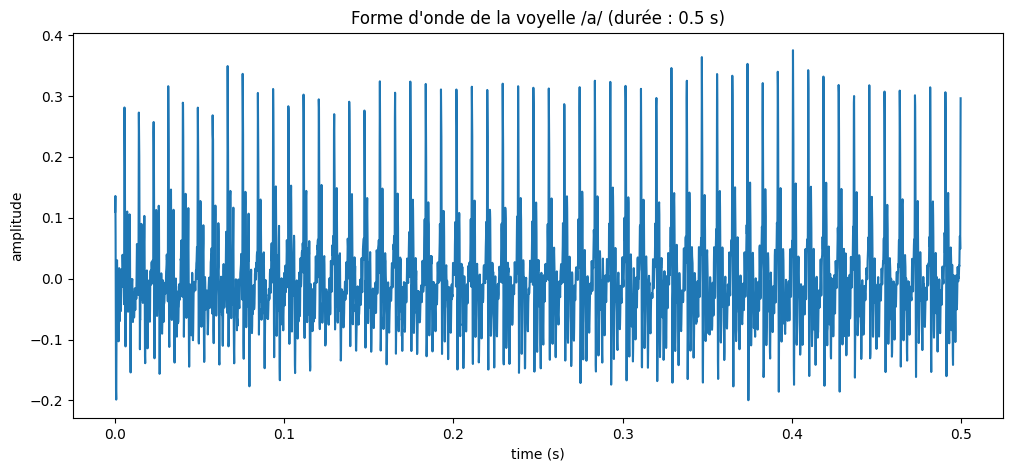

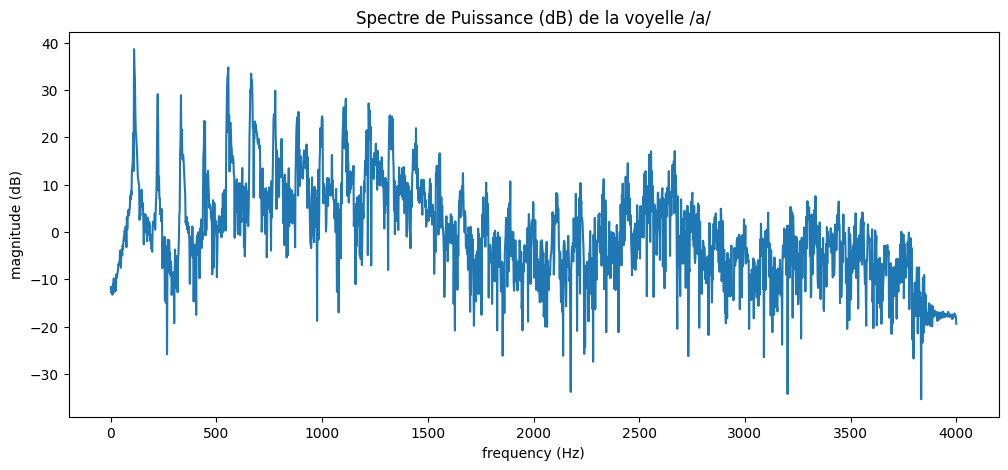

In [20]:
x= None
x_dft= None

# Q1: choix de la voyelle "a"
start_sec = 0.25
duration_sec = 0.5
start_sample = int(start_sec * fs)
end_sample = int((start_sec + duration_sec) * fs)
x = x_all[start_sample:end_sample]

# Q2
x_dft = np.fft.fft(x)

# Q3
plot_waveform(x, fs)
plt.title(f"Forme d'onde de la voyelle /a/ (durée : {duration_sec} s)")

plot_spectrum(x_dft, fs)
plt.title(f"Spectre de Puissance (dB) de la voyelle /a/")

# Q4
ipd.Audio(x, rate=fs)

---

From the spectrum, you should be able to identify the pitch of the voice (the fundamental frequency, associated with the first peak in the spectrum) and the formants (the frequencies of the resonances). You can change the vowel taken from ```x_all```, the fundamental frequency should remain the same and the formants should change.

<a id='3.2'></a>
### 3.2 - Model parameters estimation

In the following ```LPC``` function, we solve the system of equation of exercise 2.2 in order to estimate the parameters of the source-filter/LPC model of order $P$.

In [21]:
def LPC(x, P):
    """
    Computes the LPC coefficients.

    Inputs:
        x : speech signal, numpy array of shape (T,)
        P : order of the model
    Outputs:
        a : LPC coefficients, numpy array of shape (P,)
    """

    T = x.shape[0]
    R = np.zeros((P, P))
    r = np.zeros((P,1))

    for t in np.arange(P,T):
        x_P = x[t-P:t, np.newaxis] # shape (P, 1)
        x_P = np.flipud(x_P)
        R = R + x_P @ x_P.T
        r = r + x[t]*x_P

    a = -np.linalg.inv(R + 1e-6*np.eye(P))@r # add epsilon times identity for numerical stability

    return np.squeeze(a)

---

**Exercise 3.3**

Read the code of the `LPC` function to answer to the following questions.

1. Give the expression of the vector $\mathbf{x}_P \in \mathbb{R}^P$ that corresponds to the numpy array `x_P`.
2. Give the expressions of the matrix $\mathbf{R}$ and of the vector $\mathbf{r}$ in equation (5) using $\mathbf{x}_P$.

---

---
**Solution**

1. $\mathbf{x}_P(t)$ est calculé ∀ $t\in\{P,...,T-1\}$ et vaut

$$ \mathbf{x}_P(t) = \begin{pmatrix} x(t-1) \\ x(t-2) \\ \vdots \\ x(t-P) \end{pmatrix}, \forall t\in \{P, ..., T-1\} $$

2. On a

$$
\mathbf{R} = \sum_{t=P}^{T-1} \mathbf{x}_P(t) \mathbf{x}_P(t)^T,\ \mathbf{r}=\sum_{r=P}^{T-1}x(t)\mathbf{x}_P(t)
$$

En effet,

$$
\begin{aligned}
\mathbf{R} &= \begin{pmatrix}c(1, 1) & c(2, 1) & ... & c(P,1) \\ c(1, 2) & c(2, 2) & ... & c(P,2) \\ \vdots & \vdots & \ddots & \vdots \\ c(1, P) & c(2, P) & ... & c(P,P) \end{pmatrix}\\
&= \begin{pmatrix}\sum_{t=P}^{T-1}x(t-1)x(t-1) & \sum_{t=P}^{T-1}x(t-2)x(t-1) & ... & \sum_{t=P}^{T-1}x(t-P)x(t-1) \\ \sum_{t=P}^{T-1}x(t-1)x(t-2) & \sum_{t=P}^{T-1}x(t-2)x(t-2) & ... & \sum_{t=P}^{T-1}x(t-P)x(t-2) \\ \vdots & \vdots & \ddots & \vdots \\ \sum_{t=P}^{T-1}x(t-1)x(t-P) & \sum_{t=P}^{T-1}x(t-2)x(t-P) & ... & \sum_{t=P}^{T-1}x(t-P)x(t-P) \end{pmatrix} \\
&= \sum_{t=P}^{T-1}\begin{pmatrix}x(t-1)x(t-1) & x(t-2)x(t-1) & ... & x(t-P)x(t-1) \\ x(t-1)x(t-2) & x(t-2)x(t-2) & ... & x(t-P)x(t-2) \\ \vdots & \vdots & \ddots & \vdots \\ x(t-1)x(t-P) & x(t-2)x(t-P) & ... & x(t-P)x(t-P) \end{pmatrix} \\
&= \sum_{t=P}^{T-1} \mathbf{x}_P(t) \mathbf{x}_P(t)^T
\end{aligned}
$$

Et

$$
\mathbf{r} = \begin{pmatrix} c(0,1) \\ c(0, 2) \\ ... \\ c(0, P) \end{pmatrix}= \begin{pmatrix} \sum_{t=P}^{T-1}x(t)x(t-1) \\ \sum_{t=P}^{T-1}x(t)x(t-2) \\ ... \\ \sum_{t=P}^{T-1}x(t)x(t-P) \end{pmatrix}
= \sum_{t=P}^{T-1}x(t) \begin{pmatrix} x(t-1) \\ x(t)x(t-2) \\ ... \\ x(t)x(t-P) \end{pmatrix} = \sum_{r=P}^{T-1}x(t)\mathbf{x}_P(t)
$$

---

We call the LPC function to estimate the parameters of a model of order $P=16$ on the previous vowel signal.

In [22]:
P = 16
a = LPC(x, P)

print(a)

[-1.48388149  0.93272034 -0.46474986  0.6950263  -0.71308272  0.22846072
 -0.20008097  0.69903832 -0.82751161  0.48440049 -0.35275782  0.21965765
 -0.12448208  0.05854658 -0.12997434  0.12686228]


<a id='3.3'></a>

### 3.3 - Residual

---
**Exercise 3.4**

1. Complete the next cell to compute the residual (you will consider $x(t)=0$ for $t < 0$).

2. How different is the spectrum of the residual from the spectrum of the original signal?

3. Listen to the residuals obtained from different vowels, what do you observe?


---
**Solution**

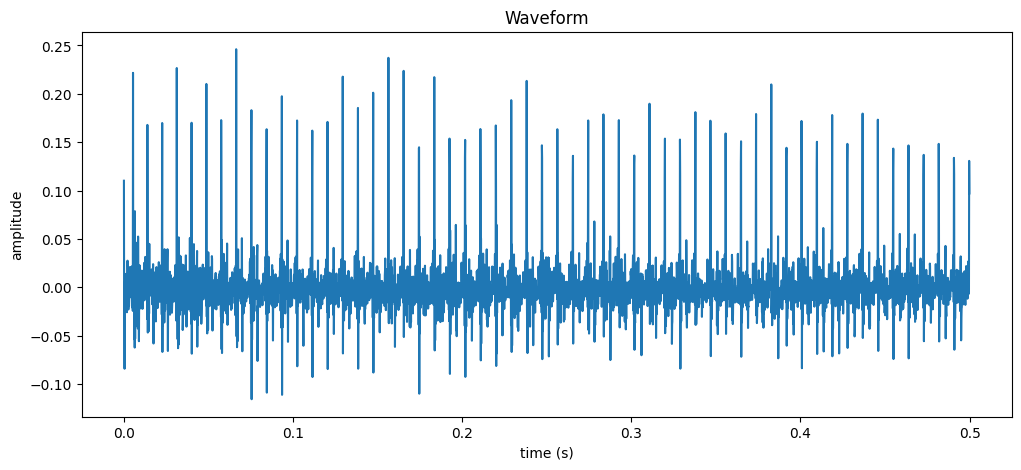

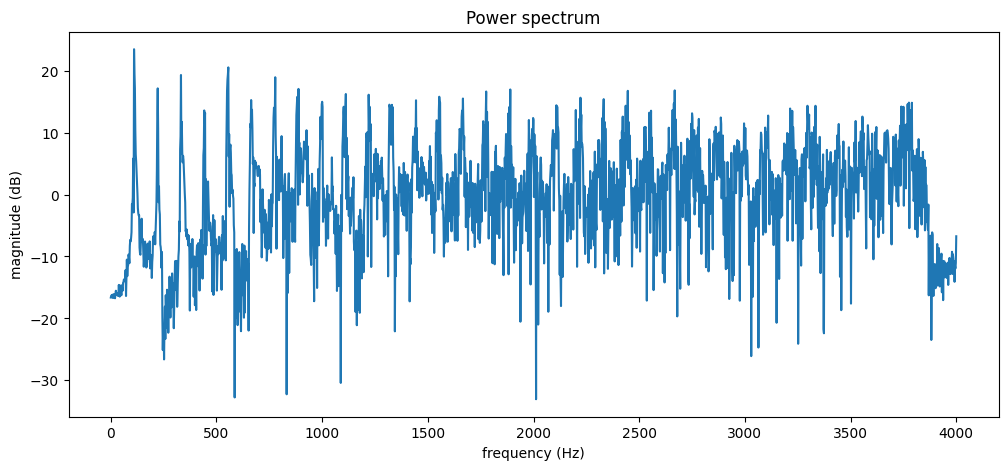

In [23]:
def residual(x, a):
    P = a.shape[0] # Récupère l'ordre P à partir des coefficients
    T = x.shape[0]
    e = np.zeros(T)

    # x_padded permet de gérer la condition x(t)=0 pour t<0
    x_padded = np.concatenate((np.zeros(P), x))

    # Les coefficients sont a = [a1, a2, ..., aP]
    # np.flipud(a) inverse a pour faciliter la convolution/sommation
    a_flipped = np.flipud(a)

    for t in np.arange(T):

        # Le segment de x retardé pour le calcul à l'instant t : x(t-1) à x(t-P)
        # Il correspond à x_padded[t : t+P] si x est de longueur T.
        x_pred_segment = x_padded[t : t + P]

        x_hat = np.dot(x_pred_segment, a_flipped) # x_hat = sum(a_i * x(t-i))

        # L'erreur (résiduelle) : e(t) = x(t) - x_hat
        e[t] = x[t] + x_hat
    return e

e = residual(x, a)

e_dft = np.fft.fft(e)

plot_waveform(e, fs)
plot_spectrum(e_dft, fs)
ipd.Audio(e, rate=fs)

**Answers**

2. Le signal analysé conserve les pics de fréquence régulièrement espacés caractéristiques des harmoniques. Cependant, l'enveloppe spectrale du signal est nettement plus homogène, car les formants (fréquences de résonance du conduit vocal) ont été éliminés.

3. Le son obtenu après cette suppression est très similaire, quelle que soit la voyelle de départ. Ce résultat est cohérent avec comment les sons sont produits, car les voyelles se distinguent uniquement par la position de leurs formants, or ces derniers sont maintenant absents. Ce signal résiduel représente le son source produit par les cordes vocales (la vibration laryngée) avant qu'il ne soit filtré et mis en forme par le conduit vocal.

---

<a id='3.4'></a>

### 3.4 - Spectral envelope


---
**Exercise 3.5**

The spectral envelope  is defined by $|H(f)|^2$. Read the code in the next cell and explain how it is computed.

---


---
**Answer**  
$H(f) = \frac{1}{1+\sum_{i=1}^P a_i e^{-j2πfi}} = \frac{1}{A(f)}$ et $ A(f) = 1+\sum_{i=1}^P a_i e^{-j2πfi} $

donc $|H(f)|^2 = \frac{1}{|A(f)|^2} $

---

Text(0.5, 1.0, 'Spectral envelope')

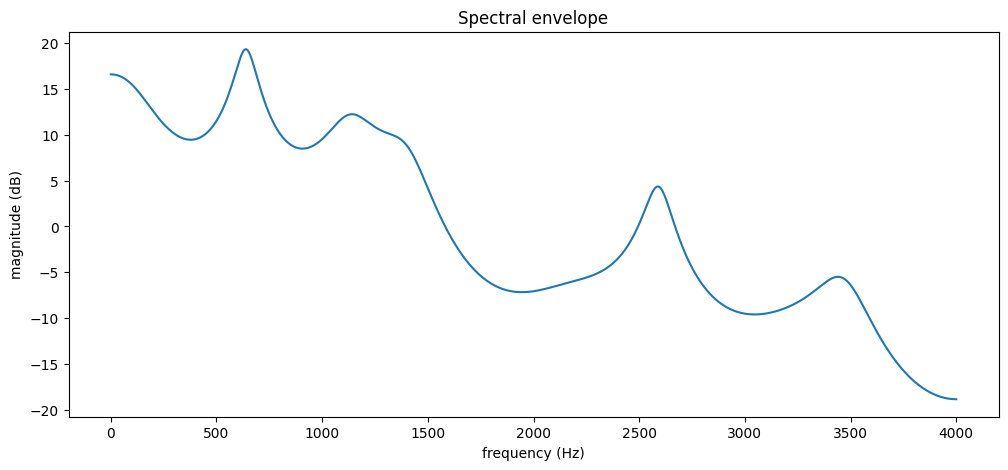

In [24]:
T = x.shape[0]
A = np.fft.fft(np.concatenate([np.array([1.]), a]), T)
spec_env = 1 / np.abs(A)**2

plot_spectrum(spec_env, fs, type='pow_spectrum')
plt.title('Spectral envelope')

The source-filter model (2) considers that the power spectrum of the speech signal is the multiplication of the source signal power spectrum with the spectral envelope:

$$ |X(f)|^2 = |H(f)|^2 |W(f)|^2. $$

In the next cell, we overlay the original speech power spectrum with the spectral envelope scaled by the average energy of the source signal (remember, source and residual are two different names that refer to the same thing).

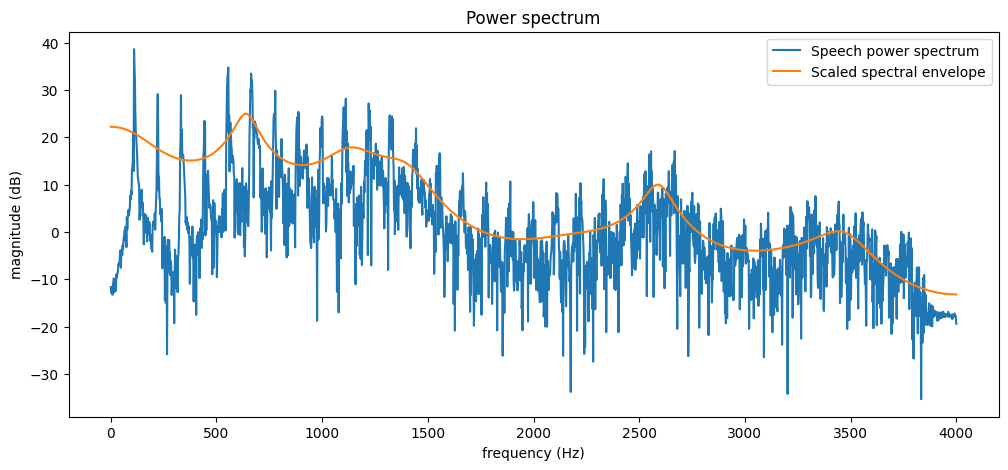

In [25]:
mean_energy_res = np.mean(np.abs(e_dft)**2)
scaled_spec_env = mean_energy_res / np.abs(A)**2

plot_spectrum(x_dft, fs)
plot_spectrum(scaled_spec_env, fs, type='pow_spectrum', new_fig=False)
plt.legend(('Speech power spectrum', 'Scaled spectral envelope'))


---
**Exercise 3.6**

What do you observe in the above figure? What change do you expect on the spectral envelope if same vowel is spoken at a different fundamental frequency?

---


---
**Answer**  
L'enveloppe spectrale correspond à une version lissée du spectre de puissance du signal. Elle conserve les fréquences de résonance principales, appelées formants, mais les harmoniques (composantes fines dues à la vibration des cordes vocales), sont effacées par ce processus de lissage. La fréquence fondamentale ($F_0$) de la voyelle n'a aucune influence sur la forme de l'enveloppe spectrale, pourvu que la voyelle prononcée (c'est-à-dire la configuration du conduit vocal) reste identique.

---

<a id='3.5'></a>
### 3.5 - Synthesis

Assume that you are now at the decoder side of an LPC-based coding system. You have received the LPC coefficients $\{a_i\}_{i=1}^P$ (potentially with additional information) and you need to synthesize a speech signal following the recursion in the source-filter model of equation (1). To do so, you need a source signal $w(t)$.

---
**Exercise 3.7**

In the next cell, we consider three different types of source signal, depending on the value of the variable `source_type`. Read the code, run it for different types of source signal, and describe the source signal corresponding to each type (by looking at the waveform, the spectrum, and by listening to the signal). What is the commonality between the spectra of the three types of source signal?

---

---
**Answer**  
1. Source A (Son Voisé = périodique)
* Temps : Elle présente des pics séparés par une périodicité de $8,33\, \text{ms}$ ($1/120\, \text{Hz}$).
* Fréquence : Son spectre montre une fréquence fondamentale ($F_0$) à $120\, \text{Hz}$ et des harmoniques d'intensité constante.

2. Source B (Son Non-Voisé = aléatoire)
* Sa forme d'onde et son spectre sont aléatoires (non-périodiques).
* Un bruit blanc gaussien.

3. Source C (Résidu): la Source C est le résidu obtenu après suppression du filtre vocal, représentant la source d'un son voisé (la vibration des cordes vocales).
---

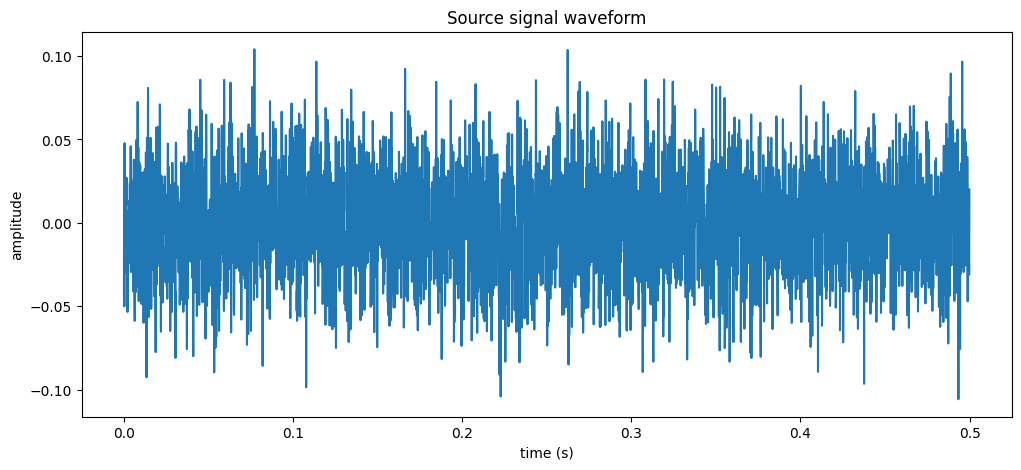

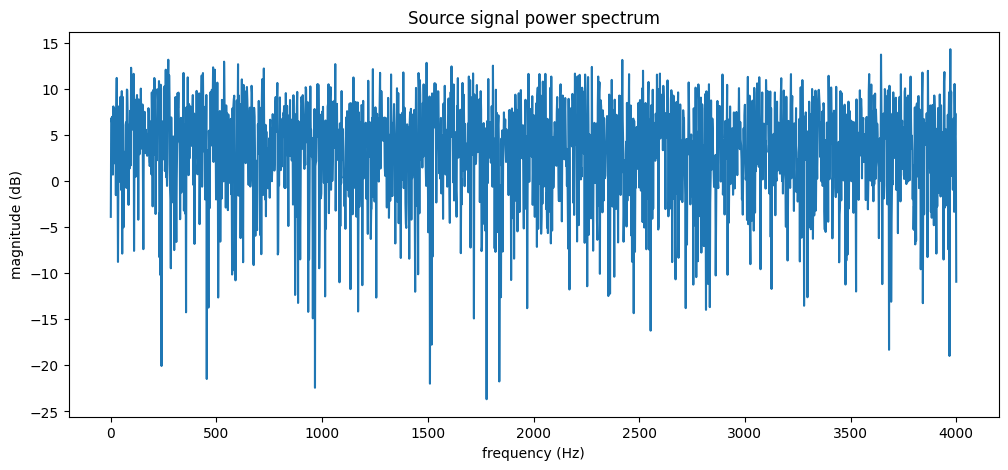

In [28]:
source_type = 'A' # 'A', 'B', or "C"
f0 = 120
T0 = int(1/f0*fs)

T = x.shape[0] # signal length

if source_type=='A':
    w = np.zeros(T)
    w[0:T:T0] = 1
elif source_type=='B':
    w = np.random.randn(T)
elif source_type=='C':
    w = e

w = w / np.sqrt(np.mean(w**2)) * np.sqrt(np.mean(e**2)) # energy normalization

w_dft = np.fft.fft(w)

plot_waveform(w, fs)
plt.title('Source signal waveform')

plot_spectrum(w_dft, fs)
plt.title('Source signal power spectrum')

ipd.Audio(w, rate=fs)


---
**Exercise 3.8**

Complete the next cell to generate recursively the speech signal following equation (1), you will consider $x(t)=0$ for $t<0$.

Describe what you obtain with different types of source signals.

---

---
**Solution**

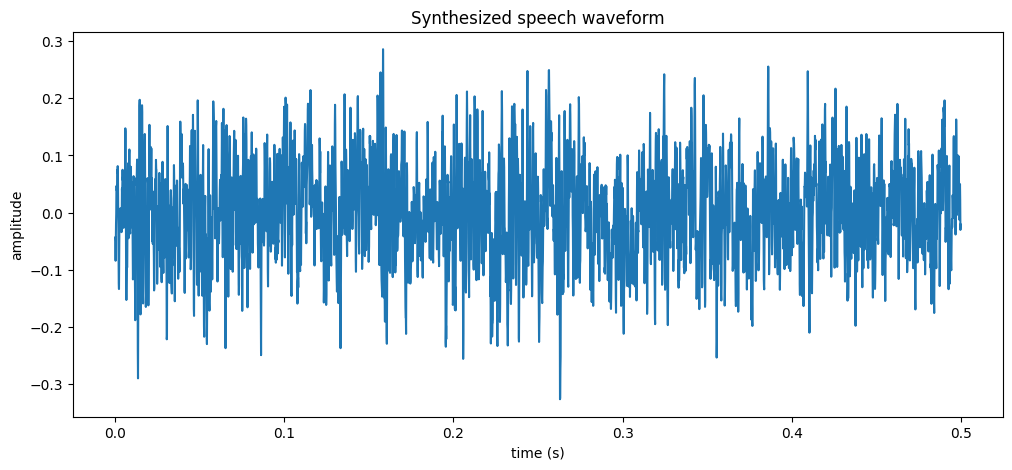

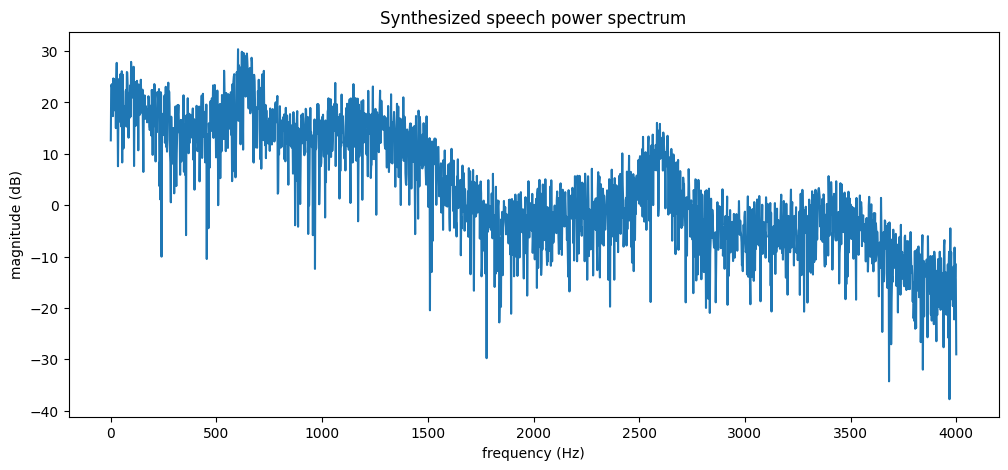

In [29]:
def synthesis(w, a):

    T = w.shape[0]
    x_gen = np.zeros(T) # used to store the synthesized speech signal

    P = a.shape[0]
    x_gen_pred =  np.zeros(P)

    for t in np.arange(T):
        x_gen[t] = w[t]
        for i in np.arange(P):
          if t>i:
            x_gen[t] -= a[i]*x_gen[t-i-1]
    return x_gen

x_gen = synthesis(w, a)

x_gen_dft = np.fft.fft(x_gen)

plot_waveform(x_gen, fs)
plt.title('Synthesized speech waveform')
plot_spectrum(x_gen_dft, fs)
plt.title('Synthesized speech power spectrum')

ipd.Audio(x_gen, rate=fs)


**Answer**


---

<a id='short-term'></a>
## 4. Short-term analysis/synthesis


In the experiments before, we analysed and synthesized a short stationary speech signal. However, in practice we have to deal with non-stationary speech signals of arbitrary length, such as the signal loaded in the next cell. You will find in the `data` folder other speech signals to play with.


In [30]:
fs = 8000
x_all, fs_x = sf.read('./data/voix_homme.wav')

if fs_x != fs:
    # resample to 8 kHz, if necessary
    ratio = float(fs) / float(fs_x)
    n_samples = int(np.ceil(x_all.shape[-1] * ratio))
    x_all = sp.signal.resample(x_all, n_samples, axis=-1)

x_all = x_all - np.mean(x_all)

ipd.Audio(x_all, rate=fs)

---
**Exercise 4.1**

We are going to use the source-filter model to analyze and synthesize the speech signal. This analysis/synthesis process should be done on short overlapping frames where we can assume that the signal is stationary. This windowing procedure is the same as the one involved in the short-time Fourier transform. The overall process is the following, for all time frames:

1. Extract a short frame of speech signal and multiply it by the analysis window.

2. Analysis/Encoding:

    a. Compute the source-filter model parameters, i.e., the LPC coefficients.

    b. Compute the residual signal and its energy.

    c. Detect if the residual signal is voiced/unvoiced. If it is voiced, compute the fundamental frequency.

3. Synthesis/Decoding:

    a. Synthesize the source signal and normalize its energy to match that of the residual. If the signal in the current analysis window is unvoiced, the source is modeled by white Gaussian noise. If the signal is voiced, the source is modeled by a periodic pulse train whose fundamental frequency corresponds to that of the residual.
    
    b. Synthesize a speech signal following the source-filter/LPC model, using the synthetic source signal and the LPC coefficients.
    
4. Perform overlap-add.

You have to complete the next cell to implement this process, you will be guided by the comments in the code.

_Remark_: The step 2.c is not implemented in the code below. To simplify the procedure we synthesize a source that is voiced or unvoiced for the whole duration of the signal. This source signal is controlled by the variables ```voiced``` and ```f0```. However, when a signal is periodic, its autocovariance function has maxima separated by the period of the fundamental. The fundamental frequency could thus be measured by finding the maximum of an estimate of the residual's normalized autocovariance function. This function could also be used to detect the voicing activity (e.g., the signal is considered voiced if the maximum of the function is above 0.5). This is left as a bonus exercise.

---

---
**Solution**

In [37]:
L = 240 # window length (30 ms @ 8 kHz)
H = 120 # hop size
P = 16 # order of the model

voiced = True # boolean indicating if voice should be voiced or not
f0 = 120 # fundamental frequency in Hz (if voiced)
T0 = int(1/f0*fs) # associated period

T = x_all.shape[0]

N = int(np.fix( (T-L)/H)) # number of frames

win = np.sin(np.arange(.5,L-.5+1)/L*np.pi); # sine analysis window

x_gen_all = np.zeros(T) # synthesized signal
e_all = np.zeros(T) # residual signal

# Loop over the frames
for n in np.arange(N):

    # select a small frame and multiply it by a smooth window, as in the STFT
    n1 = n * H
    n2 = n * H + L
    x = x_all[n1:n2]*win

    # compute the LPC coefficients
    a = LPC(x, P)

    # compute the residual and its energy
    e = residual(x, a)
    residual_energy = np.fft.fft(e)

    # synthesize the source signal
    if voiced:
        w = np.zeros(L)
        w[::T0] = 1
    else:
        w = np.random.randn(L)

    # energy normalization
    w = w / np.sqrt(np.mean(w**2)) * np.sqrt(residual_energy)

    # synthesize the speech signal
    x_gen = synthesis(w, a)

    # perform overlap-add, as in the STFT
    x_gen_all[n1:n2] += x_gen*win

    # just out of curiosity, we store the residual
    e_all[n1:n2] += e*win

/tmp/ipython-input-2249934418.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  x_gen[t] = w[t]


---

We can listen to the synthesized speech, and compare its spectrogram with the one of the original speech signal.

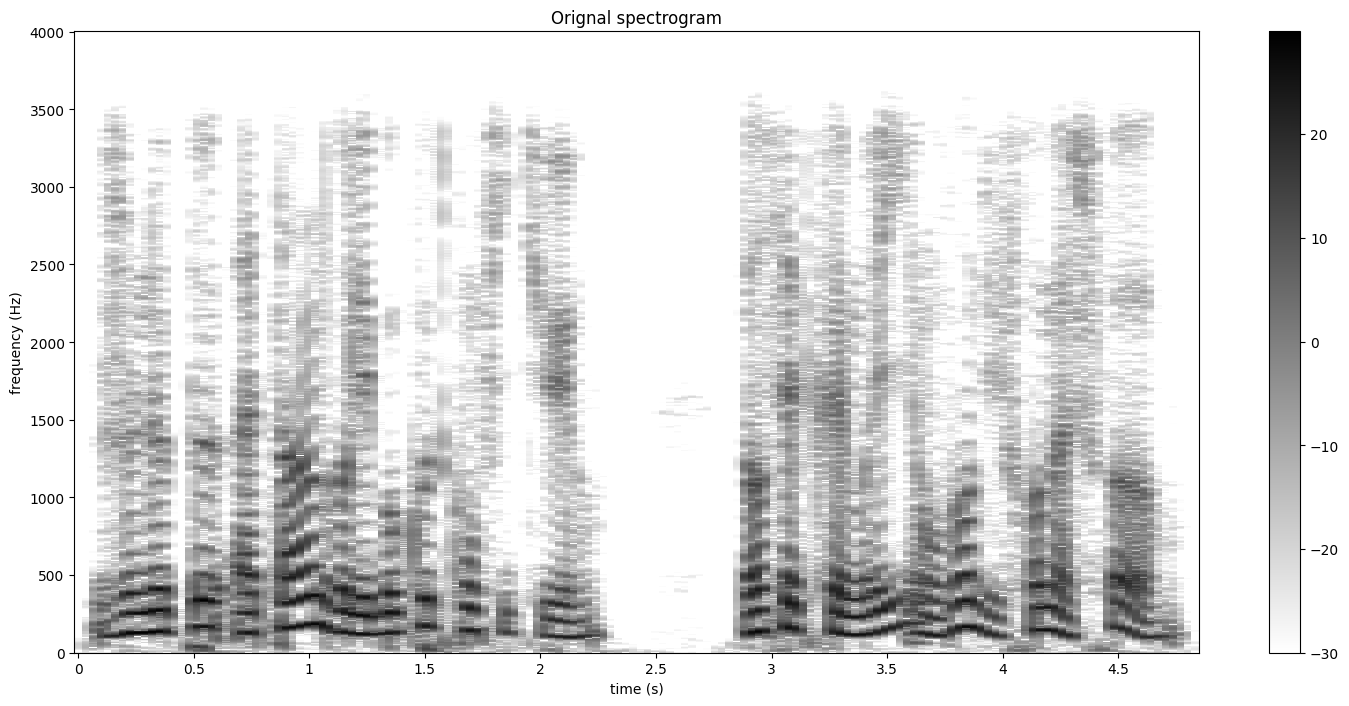

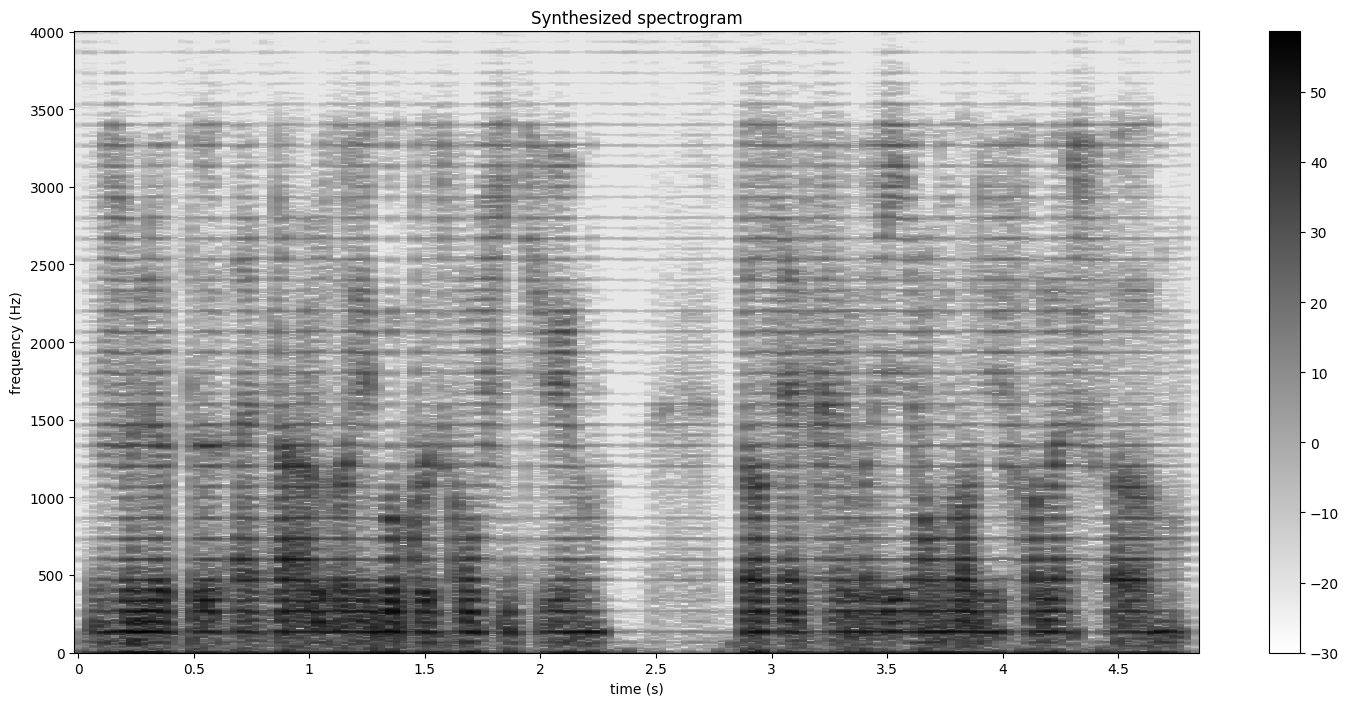

In [38]:
# Plot spectrograms
for x, title in zip([x_all, x_gen_all], ['Orignal', 'Synthesized']):

    plot_spectrogram(x, fs, wlen_sec=128e-3, hop_percent=.25)
    plt.clim(vmin=-30)
    plt.title(title + ' spectrogram')

# Audio player
ipd.Audio(x_gen_all, rate=fs)

We can also look at and listen to the residual.

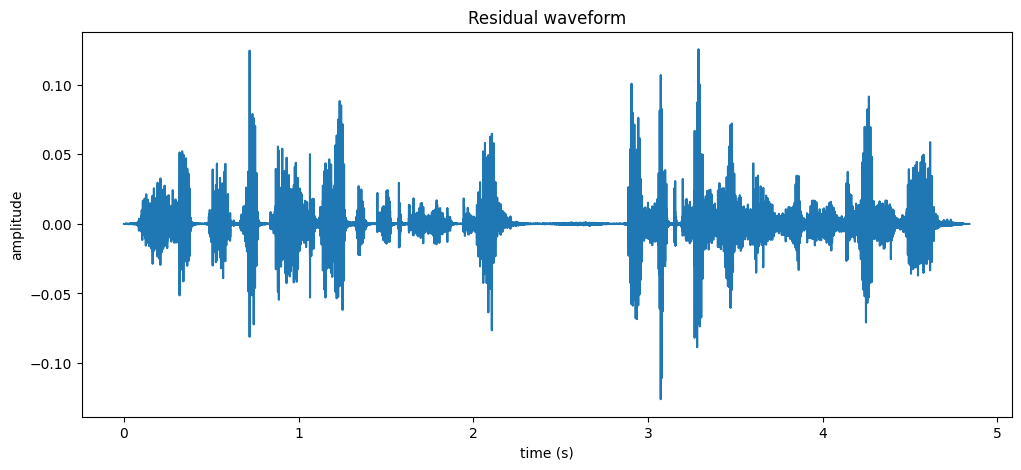

In [39]:
plot_waveform(e_all, fs)
plt.title('Residual waveform')

ipd.Audio(e_all, rate=fs)

---
**Exercise 4.2**

1. Play with the ```voiced``` and ```f0``` variables and describe their influence on the synthesized speech signal (how does it sounds, what are the characteristics of the spectrogram, etc.)

2. Propose a set of parameters that should be transmited from the encoder to reconstruct the signal at the decoder.

3. What is the bitrate for the 16-bit PCM audio format (mono) at 8 kHz?

4. Give the bitrate required to code speech using the previous LPC scheme. You can assume that any scalar parameter can be represented with 5 bits.

---

---
**Answer**

1.

2.

3.

4.

---

## 5. Cross-synthesis (bonus exercise)

Looking at LPC from an analysis/synthesis perspective allows for applications beyond coding. A good example is that of cross-synthesis.

After running LPC on a signal, we are left with a parameterization of the filter (the LPC coefficients) and an estimate of the source (the LPC residual). If we run LPC on two different signals, we can use the source of one signal and the filter of the other signal to create a hybrid output signal. This is cross-synthesis, which creates particularly interesting results when taking the filter from speech signals and the source from a spectrally rich sound texture such creaking wood.

As a bonus exercise, use the source signals loaded in the next cell to perform cross-synthesis with the previous speech signal.

In [40]:
fs = 8000

# w_all, fs_w = sf.read('./data/creak.wav')
w_all, fs_w = sf.read('./data/racing.wav')
# w_all, fs_w = sf.read('./data/bubbles.wav')

if w_all.ndim > 1:
    w_all = w_all[:,0]

if fs_w != fs:
    # resample to 8 kHz, if necessary
    ratio = float(fs) / float(fs_w)
    n_samples = int(np.ceil(w_all.shape[-1] * ratio))
    w_all = sp.signal.resample(w_all, n_samples, axis=-1)

w_all = w_all - np.mean(w_all)

w_all = w_all[:x_all.shape[0]]

ipd.Audio(w_all, rate=fs)

---
**Solution**

In [44]:
# On utilise les mêmes paramètres que dans l'Exercice 4.1
L = 240  # window length (30 ms @ 8 kHz)
H = 120  # hop size
P = 16   # order of the model

T = x_all.shape[0]

N = int(np.fix( (T-L)/H)) # number of frames

win = np.sin(np.arange(.5,L-.5+1)/L*np.pi); # sine analysis window

x_cross_synth_all = np.zeros(T) # signal de sortie pour la cross-synthèse

# Le signal source w_all est déjà chargé et prêt à être utilisé, attention il doit avoir la même longueur que x_all (T).

for n in np.arange(N):

    n1 = n * H
    n2 = n * H + L
    x = x_all[n1:n2] * win

    a = LPC(x, P)
    A = np.concatenate([[1.], a])

    w_source = w_all[n1:n2]

    e = sp.signal.lfilter(A, [1.], x)
    residual_energy = np.mean(e**2)

    source_energy = np.mean(w_source**2)
    if source_energy > 1e-10:
        w_norm = w_source / np.sqrt(source_energy) * np.sqrt(residual_energy)
    else:
        w_norm = w_source

    x_cross_synth = sp.signal.lfilter([1.], A, w_norm)

    x_cross_synth_all[n1:n2] += x_cross_synth * win

ipd.Audio(x_cross_synth_all, rate=fs)

---

## 6. References

- [Linear Predictive Coding is All-Pole Resonance Modeling](https://ccrma.stanford.edu/~hskim08/lpc/), article by Hyung-Suk Kim, Center for Computer Research in Music and Acoustics, Stanford University.
- [Time-varying linear predictive coding of speech signals](https://dspace.mit.edu/bitstream/handle/1721.1/74705/05372282-MIT.pdf?sequence=2), Doctoral dissertation at the MIT by Mark Gilbert Hall (1977).

<a id='appendix'></a>

## 7. Appendix

### The autoregressive perspective of the source-filter model

In this section, we discuss the source-filter model from the perspective of [autoregressive modeling](https://en.wikipedia.org/wiki/Autoregressive_model). This is an alternative view of linear predictive coding, where the speech signal is modeled as a stochastic process.

We consider the following **autoregressive model** of order $P$:

$$ X(t) + \sum_{i=1}^P a_i X(t-i) = W(t), \qquad (1) $$

where $W(t)$ is a white Gaussian noise of variance $\sigma_w^2$ and the polynomial $A(z) = 1 + \sum_{i=1}^P a_p z^{-p} \neq 0$ for $|z|\ge1$

It can be shown that the unique solution to (1) is given by:

$$ X(t) = h_0 W(t) + h_1 W(t-1)\,\, +\,\, ...\,\, = \sum_{k=0}^{+\infty} h_k W(t-k) = [W \star h](t), \qquad (2)$$

where $\star$ denotes the convolution operator. $X(t)$ corresponds to an **infinite impulse response filtering** of $W(t)$, whose transfer function is given by

$$\displaystyle H(z) = \frac{1}{A(z)} = \sum_{k=0}^{+\infty} h_k z^{-k}.$$

The coefficients $\{h_k\}_{k=0}^{+\infty}$ are the coefficients of the impulse response. This transfer function exhibits resonances at the zeros of the polynomial $A(z)$, which are called the poles of the filter.

**For speech modeling, $W(t)$ represents the unvoiced source signal, $H(z)$ the transfer function of the vocal tract filter, and $X(t)$ the resulting speech signal. In practice, we assume that for voiced speech sounds, only the source signal $W(t)$ changes, and it corresponds to a periodic pulse train. However, for the theoretical analysis, we assume that $W(t)$ is a white Gaussian noise.**

We can show that $X(t)$ is a wide-sense stationary (WSS) random process, in particular:

- The mean $\mathbb{E}[X(t)] = 0$ does not depend on $t$
- $\mathbb{E}[|X(t)|^2] < \infty$
- The autocovariance function $R(k) = \mathbb{E}[X(t)X(t+k)]$ only depends on $k$.

We recall that because $X(t)$ is WSS, $R(k) = R(-k)$, so in the following we limit the study to $k \ge 0$.

Also, as $W(t)$ is a white Gaussian noise of variance $\sigma_w^2$, we have:
- $\mathbb{E}[W(t)] = 0$
- $\mathbb{E}[|W(t)|^2] = \sigma_w^2$
- $\mathbb{E}[W(t)W(t+k)] = 0$ for $k \neq 0$.


### Estimating the model parameters by solving Yule-Walker equations

In this section we will see how to compute the parameters of this model from an observation of the random process $X(t)$. The model parameters are the autoregressive coefficients $\{a_1, ..., a_P\}$ and the noise variance $\sigma_w^2$, involved in (1).

1. Using (2), we can show that

$$\mathbb{E}[X(t-k)W(t)] = 0, \qquad \forall k \ge 1. \qquad (3)$$

2. Using (1) and (3), we can show that

$$\mathbb{E}[X(t)W(t)] = \sigma_w^2. \qquad (4)$$

3. Using (1), (3) and (4), we can show that the covariance function $R(k) = \mathbb{E}[X(t)X(t+k)]$ satisfies

  $$R(k) + \sum_{i=1}^P a_i R(k-i) = 0, \qquad \forall k \ge 1. \qquad (5)$$
  $$R(0) + \sum_{i=1}^P a_i R(i) = \sigma_w^2.  \qquad (6)$$
  
Combining (5) and (6) we obtain the **Yule-Walker equations**:

\begin{equation}
\begin{pmatrix}
R(0) & R(1) & \cdots & R(P) \\
R(1) & R(0) & \cdots & R(P-1) \\
\vdots  & \vdots  & \ddots & \vdots  \\
R(P) & R(P-1) & \cdots & R(0)
\end{pmatrix}
\begin{pmatrix}
1 \\
a_1 \\
\vdots \\
a_P
\end{pmatrix}=
\begin{pmatrix}
\sigma_w^2 \\
0 \\
\vdots \\
0
\end{pmatrix}. \qquad (7)
\end{equation}

(6) gives the first line of this system of equations, and (5) the other ones. In (7), we have $P+1$ equations for $P+1$ unknowns (the $P$ AR cofficients and the noise variance). **We can therefore solve this system to estimate the model parameters**.

In practice, we have $T$ data coefficients $x(0),..., x(T-1)$ and we replace the autocovariance function $R(k)$ in (7) by the empirical autocovariance function:

$$ \hat{R}(k) = \frac{1}{T} \sum_{t=0}^{T-1-k} x(t) x(t+k), \qquad k \ge 0. \qquad (8) $$

For $k < 0$, $\hat{R}(k) = \hat{R}(-k)$.

In [ ]:
def LPC_AR(x, P):

    T = x.shape[0]

    r = np.zeros(P+1)

    for i in np.arange(P+1):

        x1 = x[i:T]
        x2 = x[:T-i]
        r[i] = 1/T*np.sum(x1*x2)

    R = sp.linalg.toeplitz(r[:P])
    a = -np.linalg.inv(R)@r[1:]
    sigma2 = np.sum(r * np.concatenate([np.array([1.]), a]))

    return a, sigma2

### Power spectral density

The power spectral density (PSD) of the process $X(t)$ is defined by the discrete-time Fourier transform (DTFT) of the autocovariance function:

$$ S_X(\nu) = \sum_{k=-\infty}^{+\infty} R(k) e^{-j 2 \pi \nu k}, \qquad \nu \in [0,1[. \qquad (9) $$

The PSD represents the repartition of the energy of the random process in the frequency domain.

For the AR model (1), we can show that the PSD is equal to:

$$ S_{X}(\nu) = | H(\nu) |^2 S_{W}(\nu), \qquad \nu \in [0,1[, \qquad (10)$$

where

- $S_{W}(\nu) = \sigma_w ^2$ is the DSP of the source signal. We say that the source is **white**, because its DSP is constant over the frequency.

- $\displaystyle H(\nu) = \frac{1}{ 1 + \sum_{p=1}^P a_p  e^{-j 2 \pi \nu p}} $ is the transfer function of an all-pole filter, which accounts for the resonances in the vocal tract.

- $| H(\nu) |^2$ is called the **spectral envelope** of the speech signal.

In practice, given $T$ data $x(0),..., x(T-1)$, we estimate the PSD by the **periodogram**, which is defined by:

$$ \hat{S}_X(\nu) = \sum_{k=-(T-1)}^{T-1} \hat{R}(k) e^{-j 2 \pi \nu k} = \frac{1}{T} \Big| \sum_{t=0}^{T-1} x(t) e^{-j 2 \pi \nu t} \Big|^2. \qquad (11)$$

**We see that the periodogram is simply the scaled power spectrum of the signal.**

Identifying (10) and (11) we have:

$$ \frac{1}{T} \Big| \sum_{t=0}^{T-1} x(t) e^{-j 2 \pi \nu t} \Big|^2 = \frac{\hat{\sigma}_w ^2}{ \Big| 1 + \sum_{p=1}^P \hat{a}_p  e^{-j 2 \pi \nu p} \Big|^2}, \qquad (12) $$

where $\hat{a}_p$ and $\hat{\sigma}_w ^2$ are estimates of the AR model parameters, obtained by solving the Yule-Walker equations.

**Equation (12) can be interpreted as follows: The spectrum of the speech signal is equal to the multiplication of (i) the flat spectrum of the source signal, and (ii) the frequency response of the all-pole filter which models the resonances (i.e. formants) in the vocal tract.**

### Pre-Emphasis

In speech processing, a process called pre-emphasis is applied to the input signal before the LPC analysis. During the reconstruction following the LPC analysis, a de-emphasis process is applied to the signal to reverse the effects of pre-emphasis.

Pre- and de- emphasis are necessary because, in the spectrum of a human speech signal, the energy in the signal decreases as the frequency increases. Pre-emphasis increases the energy in parts of the signal by an amount inversely proportional to its frequency. Thus, as the frequency increases, pre-emphasis raises the energy of the speech signal by an increasing amount. This process therefore serves to flatten the signal so that the resulting spectrum consists of formants of similar heights. (Formants are the highly visible resonances or peaks in the spectrum of the speech signal, where most of the energy is concentrated.) The flatter spectrum allows the LPC analysis to more accurately model the speech segment. Without pre-emphasis, the linear prediction would incorrectly focus on the lower-frequency components of speech, losing important information about certain sounds.

In [ ]:
def preemphasis(x):
    return sp.signal.lfilter(np.array([1, -0.976]), 1, x)

def deemphasis(x):
    return sp.signal.lfilter(np.array([1, 0]), np.array([1, -0.976]), x)

In [ ]:
y = preemphasis(x)
x_rec = deemphasis(y)
plt.plot(x)
plt.plot(x_rec, '--')